# Dimensionality reduction benchmark on DLPFC slides (Fig S26)

In [1]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from plotnine import *

from smoother import SpatialWeightMatrix, SpatialLoss, ContrastiveSpatialLoss
from smoother.models.reduction import SpatialPCA, SpatialAutoEncoder

import scanpy as sc
import anndata

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def _load_adata_and_loss(data_dir):
    data = sc.read_h5ad(data_dir)

    # preprocessing
    sc.pp.filter_genes(data, min_counts=3)
    data.layers['raw'] = data.X.copy()
    
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    data.layers['log1p'] = data.X.copy()
    
    sc.pp.highly_variable_genes(
        data, subset=True, n_top_genes=2000, layer="log1p"
    )

    sc.pp.scale(data, layer='log1p', 
                zero_center=True, max_value=10, copy=False)
    data.layers['scaled'] = data.X.copy()

    # prepare spatial loss
    y = data.layers['log1p']
    y = torch.tensor(y).T
    coords = data.obsm['spatial']
    
    weights = SpatialWeightMatrix()
    weights.calc_weights_knn(coords)
    weights.scale_by_expr(y)

    sp_loss = SpatialLoss('icar', weights, 0.99, standardize_cov=False)
    cont_sp_loss = ContrastiveSpatialLoss('icar', weights, 0.99, standardize_cov=False)

    return data, sp_loss, cont_sp_loss

## Spatial PCA

In [3]:
def _run_pca(data, sp_loss, cont_sp_loss, l_sp_losses = [0, 1]):
    torch.manual_seed(20230710)

    baseline = SpatialPCA(data, layer='scaled', n_latent=30)
    baseline.reduce(lr=1, max_epochs=-1, verbose=False, init_with_svd=True, quite=True)

    model_list = []
    names_list = []
    for l_sp in l_sp_losses:
        model_sp = SpatialPCA.from_rna_model(
            rna_model=baseline, st_adata=data, layer='scaled',
            spatial_loss=sp_loss, lambda_spatial_loss=l_sp
        )
        model_list.append(model_sp)
        names_list.append(f"PCA_sp_{l_sp}")

        model_csp = SpatialPCA.from_rna_model(
            rna_model=baseline, st_adata=data, layer='scaled',
            spatial_loss=cont_sp_loss, lambda_spatial_loss=l_sp
        )
        model_list.append(model_csp)
        names_list.append(f"PCA_csp_{l_sp}")

    X_latent = []
    dr_time = []
    # run reduction
    for m, n in zip(model_list, names_list):
        m.reduce(lr=1e-1, max_epochs=-1, verbose=False, init_with_svd=False, quite=True)
        X_latent.append(m.get_latent_representation())
        dr_time.append(m.dr_logs['elapsed_time'] + baseline.dr_logs['elapsed_time'])

    dr_time = pd.DataFrame({'base':'PCA',
                            'model': names_list,
                            'l_sp': np.repeat(l_sp_losses, 2),
                            'runtime': dr_time
                           })
    
    return X_latent, dr_time

def run_all_pca(sample_id, l_sp_losses = [0, 1, 3, 10]):
    data_dir = "/Users/jysumac/Projects/Smoother_paper/data/dlpfc_sodb/" \
                    f"10X_Visium_maynard2021trans_{sample_id}_data.h5ad"
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/PCA"

    # run dr
    data, sp_loss, cont_sp_loss = _load_adata_and_loss(data_dir)
    print('Running PCA ...')
    X_latent, dr_time = _run_pca(data, sp_loss, cont_sp_loss, l_sp_losses)

    # save results
    for m, x in zip(dr_time['model'], X_latent):
        np.savetxt(f"{res_dir}/{sample_id}_{m}.txt", x)
    
    dr_time['sample_id'] = sample_id
    dr_time.to_csv(res_dir + f"{sample_id}_runtime_PCA.csv")

### Single sample

In [5]:
run_all_pca('151509')

/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4789. Average number of neighbors per spot:  5.90.
Number of spots: 4789. Average number of neighbors per spot:  5.90.
Running PCA ...


### All samples

In [6]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]
l_sp_losses = [0, 1, 3, 10]

for s in sample_ids:
    run_all_pca(s, l_sp_losses)

/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4226. Average number of neighbors per spot:  5.89.
Number of spots: 4226. Average number of neighbors per spot:  5.89.
Running PCA ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_sppca.py:201: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4384. Average number of neighbors per spot:  5.88.
Number of spots: 4384. Average number of neighbors per spot:  5.89.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4789. Average number of neighbors per spot:  5.90.
Number of spots: 4789. Average number of neighbors per spot:  5.90.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4634. Average number of neighbors per spot:  5.89.
Number of spots: 4634. Average number of neighbors per spot:  5.89.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3661. Average number of neighbors per spot:  5.85.
Number of spots: 3661. Average number of neighbors per spot:  5.85.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3498. Average number of neighbors per spot:  5.87.
Number of spots: 3498. Average number of neighbors per spot:  5.88.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4110. Average number of neighbors per spot:  5.88.
Number of spots: 4110. Average number of neighbors per spot:  5.89.
Running PCA ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_sppca.py:201: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4015. Average number of neighbors per spot:  5.87.
Number of spots: 4015. Average number of neighbors per spot:  5.88.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3639. Average number of neighbors per spot:  5.85.
Number of spots: 3639. Average number of neighbors per spot:  5.86.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3673. Average number of neighbors per spot:  5.85.
Number of spots: 3673. Average number of neighbors per spot:  5.85.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3592. Average number of neighbors per spot:  5.85.
Number of spots: 3592. Average number of neighbors per spot:  5.85.
Running PCA ...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3460. Average number of neighbors per spot:  5.85.
Number of spots: 3460. Average number of neighbors per spot:  5.85.
Running PCA ...


## Spatial AE

In [7]:
def _run_ae(data, sp_loss, cont_sp_loss, l_sp_losses = [0, 1]):
    torch.manual_seed(20230710)

    baseline = SpatialAutoEncoder(
            data, layer='log1p', 
            n_layers=2, n_latent=30,
            lambda_orth_loss=0.01,
            recon_loss_mode='mse',
            activation_fn=torch.nn.ELU
    )
    baseline.reduce(lr = 3e-3, max_epochs=200, verbose=False, quite=True)

    model_list = []
    names_list = []
    for l_sp in l_sp_losses:
        model_sp = SpatialAutoEncoder.from_rna_model(
            rna_model=baseline, st_adata=data, layer='log1p',
            spatial_loss=sp_loss, lambda_spatial_loss=l_sp
        )
        model_list.append(model_sp)
        names_list.append(f"AE_sp_{l_sp}")
        
        model_csp = SpatialAutoEncoder.from_rna_model(
            rna_model=baseline, st_adata=data, layer='log1p',
            spatial_loss=cont_sp_loss, lambda_spatial_loss=l_sp
        )
        model_list.append(model_csp)
        names_list.append(f"AE_csp_{l_sp}")

    X_latent = []
    dr_time = []
    # run reduction
    for m, n in zip(model_list, names_list):
        m.reduce(lr=3e-4, max_epochs=200, verbose=False, quite=True)
        X_latent.append(m.get_latent_representation())
        dr_time.append(m.dr_logs['elapsed_time'] + baseline.dr_logs['elapsed_time'])

    dr_time = pd.DataFrame({'base':'AE',
                            'model': names_list,
                            'l_sp': np.repeat(l_sp_losses, 2),
                            'runtime': dr_time
                           })
    
    return X_latent, dr_time

def run_all_ae(sample_id, l_sp_losses = [0, 1, 3, 10]):
    data_dir = "/Users/jysumac/Projects/Smoother_paper/data/dlpfc_sodb/" \
                    f"10X_Visium_maynard2021trans_{sample_id}_data.h5ad"
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/AE/"

    # run dr
    data, sp_loss, cont_sp_loss = _load_adata_and_loss(data_dir)
    print('Running AE ...')
    X_latent, dr_time = _run_ae(data, sp_loss, cont_sp_loss, l_sp_losses)

    # save results
    for m, x in zip(dr_time['model'], X_latent):
        np.savetxt(f"{res_dir}/{sample_id}_{m}.txt", x)
    
    dr_time['sample_id'] = sample_id
    dr_time.to_csv(res_dir + f"{sample_id}_runtime_AE.csv")


### Single sample

In [8]:
run_all_ae('151509')

/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4789. Average number of neighbors per spot:  5.90.
Number of spots: 4789. Average number of neighbors per spot:  5.90.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


### All samples

In [9]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]
l_sp_losses = [0, 1, 3, 10]

for s in sample_ids:
    run_all_ae(s, l_sp_losses)

/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4226. Average number of neighbors per spot:  5.89.
Number of spots: 4226. Average number of neighbors per spot:  5.89.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4384. Average number of neighbors per spot:  5.88.
Number of spots: 4384. Average number of neighbors per spot:  5.89.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4789. Average number of neighbors per spot:  5.90.
Number of spots: 4789. Average number of neighbors per spot:  5.90.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4634. Average number of neighbors per spot:  5.89.
Number of spots: 4634. Average number of neighbors per spot:  5.89.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3661. Average number of neighbors per spot:  5.85.
Number of spots: 3661. Average number of neighbors per spot:  5.85.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3498. Average number of neighbors per spot:  5.87.
Number of spots: 3498. Average number of neighbors per spot:  5.88.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4110. Average number of neighbors per spot:  5.88.
Number of spots: 4110. Average number of neighbors per spot:  5.89.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 4015. Average number of neighbors per spot:  5.87.
Number of spots: 4015. Average number of neighbors per spot:  5.88.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3639. Average number of neighbors per spot:  5.85.
Number of spots: 3639. Average number of neighbors per spot:  5.86.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3673. Average number of neighbors per spot:  5.85.
Number of spots: 3673. Average number of neighbors per spot:  5.85.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3592. Average number of neighbors per spot:  5.85.
Number of spots: 3592. Average number of neighbors per spot:  5.85.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Number of spots: 3460. Average number of neighbors per spot:  5.85.
Number of spots: 3460. Average number of neighbors per spot:  5.85.
Running AE ...


/Users/jysumac/Projects/Smoother/smoother/models/reduction/_spae.py:224: UserWarning: Fail to converge. Try to increase 'max_epochs'.


## STAGATE

In [10]:
import STAGATE_pyG as STAGATE

def _run_stagate(data_dir):
    data = sc.read_h5ad(data_dir)

    # preprocessing
    sc.pp.filter_genes(data, min_counts=3)
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    data.layers['log1p'] = data.X.copy()
    sc.pp.highly_variable_genes(
        data, subset=True, n_top_genes=2000, layer="log1p"
    )

    # run STAGATE
    STAGATE.Cal_Spatial_Net(data, rad_cutoff=150)
    data = STAGATE.train_STAGATE(data, hidden_dims=[128, 30])

    return data

def run_stagate(sample_id):
    data_dir = "/Users/jysumac/Projects/Smoother_paper/data/dlpfc_sodb/" \
                    f"10X_Visium_maynard2021trans_{sample_id}_data.h5ad"
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/STAGATE/"

    # run dr
    data = _run_stagate(data_dir)
    # save results
    np.savetxt(f"{res_dir}/{sample_id}_STAGATE.txt", data.obsm['STAGATE'])

### All samples

In [11]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]

for s in sample_ids:
    run_stagate(s)

/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 24770 edges, 4226 cells.
5.8613 neighbors per cell on average.
Size of Input:  (4226, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 25698 edges, 4384 cells.
5.8618 neighbors per cell on average.
Size of Input:  (4384, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:16<00:00,  7.33it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 28172 edges, 4789 cells.
5.8826 neighbors per cell on average.
Size of Input:  (4789, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:28<00:00,  6.73it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 27198 edges, 4634 cells.
5.8692 neighbors per cell on average.
Size of Input:  (4634, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 21194 edges, 3661 cells.
5.7891 neighbors per cell on average.
Size of Input:  (3661, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:07<00:00,  7.85it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 20370 edges, 3498 cells.
5.8233 neighbors per cell on average.
Size of Input:  (3498, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:03<00:00,  8.12it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 24052 edges, 4110 cells.
5.8521 neighbors per cell on average.
Size of Input:  (4110, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:31<00:00,  6.60it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 23382 edges, 4015 cells.
5.8237 neighbors per cell on average.
Size of Input:  (4015, 2000)


100%|███████████████████████████████████████| 1000/1000 [02:20<00:00,  7.13it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
Size of Input:  (3639, 2000)


100%|███████████████████████████████████████| 1000/1000 [01:51<00:00,  8.95it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
Size of Input:  (3673, 2000)


100%|███████████████████████████████████████| 1000/1000 [01:51<00:00,  8.94it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
Size of Input:  (3592, 2000)


100%|███████████████████████████████████████| 1000/1000 [01:46<00:00,  9.38it/s]


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


/Users/jysumac/miniforge3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Size of Input:  (3460, 2000)


100%|███████████████████████████████████████| 1000/1000 [01:48<00:00,  9.22it/s]


### Single sample

In [6]:
data = STAGATE.train_STAGATE(data)

Size of Input:  (3639, 2000)


100%|███████████████████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]


In [22]:
data

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'leiden', 'STAGATE'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'Spatial_Net'
    obsm: 'X_pca', 'X_umap', 'spatial', 'STAGATE'
    varm: 'PCs'
    layers: 'raw', 'log1p'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [8]:
sc.pp.neighbors(data, use_rep='STAGATE')
sc.tl.umap(data)

In [9]:
sc.tl.leiden(data, key_added='STAGATE', resolution=0.5)

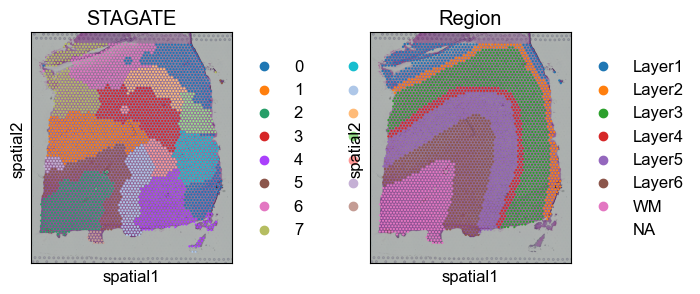

In [43]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(data, color=["mclust", "Region"], title=['STAGATE', "Region"])

## SpaceFlow

In [3]:
from SpaceFlow import SpaceFlow

def run_sf(sample_id):
    data_dir = "/Users/jysumac/Projects/Smoother_paper/data/dlpfc_sodb/" \
                    f"10X_Visium_maynard2021trans_{sample_id}_data.h5ad"
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/SpaceFlow/"
    data = sc.read_h5ad(data_dir)
    
    # preprocessing
    sc.pp.filter_genes(data, min_counts=3)
    data.layers['raw'] = data.X.copy()
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    data.layers['log1p'] = data.X.copy()
    sc.pp.highly_variable_genes(
        data, subset=True, n_top_genes=2000, layer="log1p"
    )

    sf = SpaceFlow.SpaceFlow(
        count_matrix=data.layers['raw'][:, data.var['highly_variable']], 
        spatial_locs=data.obsm['spatial'], 
        sample_names=data.obs_names, 
        gene_names=data.var_names[data.var['highly_variable']]
    )

    sf.preprocessing_data(n_top_genes=2000)
    sf.train(
        embedding_save_filepath=f"{res_dir}/{sample_id}_SF.tsv",
        spatial_regularization_strength=0.1, 
        z_dim=30, lr=1e-3, epochs=1000, max_patience=50, min_stop=100, random_seed=42, 
        gpu=0, regularization_acceleration=True, edge_subset_sz=1000000
    )

### All samples

In [4]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]

for s in sample_ids:
    run_sf(s)

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.7715833187103271
Epoch 12/1000, Loss: 1.452147126197815
Epoch 22/1000, Loss: 1.4185386896133423
Epoch 32/1000, Loss: 1.3820738792419434
Epoch 42/1000, Loss: 1.277362585067749
Epoch 52/1000, Loss: 1.012333869934082
Epoch 62/1000, Loss: 0.6529843807220459
Epoch 72/1000, Loss: 0.39172670245170593
Epoch 82/1000, Loss: 0.22978204488754272
Epoch 92/1000, Loss: 0.17692133784294128
Epoch 102/1000, Loss: 0.1310402750968933
Epoch 112/1000, Loss: 0.10808029770851135
Epoch 122/1000, Loss: 0.09790942072868347
Epoch 132/1000, Loss: 0.09428286552429199
Epoch 142/1000, Loss: 0.08040204644203186
Epoch 152/1000, Loss: 0.08018264174461365
Epoch 162/1000, Loss: 0.06750058382749557
Epoch 172/1000, Loss: 0.06764069199562073
Epoch 182/1000, Loss: 0.07311490923166275
Epoch 192/1000, Loss: 0.06837836652994156
Epoch 202/1000, Loss: 0.067458376288414
Epoch 212/1000, Loss: 0.06074560433626175
Epoch 222/1000, Loss: 0.05868478864431381
Epoch 232/1000, Loss: 0.053867556154727936
Epoch 242/1000,

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.5239754915237427
Epoch 12/1000, Loss: 1.4490208625793457
Epoch 22/1000, Loss: 1.4190669059753418
Epoch 32/1000, Loss: 1.3712257146835327
Epoch 42/1000, Loss: 1.242766261100769
Epoch 52/1000, Loss: 0.9632858037948608
Epoch 62/1000, Loss: 0.6560856103897095
Epoch 72/1000, Loss: 0.39083340764045715
Epoch 82/1000, Loss: 0.2483808994293213
Epoch 92/1000, Loss: 0.17284797132015228
Epoch 102/1000, Loss: 0.12278106063604355
Epoch 112/1000, Loss: 0.11013735085725784
Epoch 122/1000, Loss: 0.10117559134960175
Epoch 132/1000, Loss: 0.0864637941122055
Epoch 142/1000, Loss: 0.06876485794782639
Epoch 152/1000, Loss: 0.08388109505176544
Epoch 162/1000, Loss: 0.07305850088596344
Epoch 172/1000, Loss: 0.058407384902238846
Epoch 182/1000, Loss: 0.05910998582839966
Epoch 192/1000, Loss: 0.05555226653814316
Epoch 202/1000, Loss: 0.05593085289001465
Epoch 212/1000, Loss: 0.05563277378678322
Epoch 222/1000, Loss: 0.05745760351419449
Epoch 232/1000, Loss: 0.04990842565894127
Epoch 242/10

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.6247353553771973
Epoch 12/1000, Loss: 1.4602867364883423
Epoch 22/1000, Loss: 1.4383447170257568
Epoch 32/1000, Loss: 1.4206640720367432
Epoch 42/1000, Loss: 1.3844889402389526
Epoch 52/1000, Loss: 1.3000905513763428
Epoch 62/1000, Loss: 1.117083191871643
Epoch 72/1000, Loss: 0.7918084859848022
Epoch 82/1000, Loss: 0.4778609871864319
Epoch 92/1000, Loss: 0.29396817088127136
Epoch 102/1000, Loss: 0.18300563097000122
Epoch 112/1000, Loss: 0.1432783156633377
Epoch 122/1000, Loss: 0.11311838030815125
Epoch 132/1000, Loss: 0.0952538400888443
Epoch 142/1000, Loss: 0.08980533480644226
Epoch 152/1000, Loss: 0.0775809958577156
Epoch 162/1000, Loss: 0.07813712954521179
Epoch 172/1000, Loss: 0.06907893717288971
Epoch 182/1000, Loss: 0.07943558692932129
Epoch 192/1000, Loss: 0.06692768633365631
Epoch 202/1000, Loss: 0.06390033662319183
Epoch 212/1000, Loss: 0.05698022246360779
Epoch 222/1000, Loss: 0.06499145179986954
Epoch 232/1000, Loss: 0.05673936381936073
Epoch 242/1000, 

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 2.123004674911499
Epoch 12/1000, Loss: 1.4964509010314941
Epoch 22/1000, Loss: 1.445395588874817
Epoch 32/1000, Loss: 1.4376050233840942
Epoch 42/1000, Loss: 1.4228957891464233
Epoch 52/1000, Loss: 1.4062422513961792
Epoch 62/1000, Loss: 1.3816717863082886
Epoch 72/1000, Loss: 1.3320471048355103
Epoch 82/1000, Loss: 1.245097279548645
Epoch 92/1000, Loss: 1.0718374252319336
Epoch 102/1000, Loss: 0.8171795606613159
Epoch 112/1000, Loss: 0.549933671951294
Epoch 122/1000, Loss: 0.3715071380138397
Epoch 132/1000, Loss: 0.26045215129852295
Epoch 142/1000, Loss: 0.1974102258682251
Epoch 152/1000, Loss: 0.151846244931221
Epoch 162/1000, Loss: 0.13205009698867798
Epoch 172/1000, Loss: 0.11315621435642242
Epoch 182/1000, Loss: 0.12050794064998627
Epoch 192/1000, Loss: 0.0985221266746521
Epoch 202/1000, Loss: 0.0965491309762001
Epoch 212/1000, Loss: 0.08458468317985535
Epoch 222/1000, Loss: 0.08236460387706757
Epoch 232/1000, Loss: 0.07291403412818909
Epoch 242/1000, Loss: 0.0

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.937086582183838
Epoch 12/1000, Loss: 1.464392066001892
Epoch 22/1000, Loss: 1.451731562614441
Epoch 32/1000, Loss: 1.4378920793533325
Epoch 42/1000, Loss: 1.4210178852081299
Epoch 52/1000, Loss: 1.3998541831970215
Epoch 62/1000, Loss: 1.3520127534866333
Epoch 72/1000, Loss: 1.2164912223815918
Epoch 82/1000, Loss: 0.9536612033843994
Epoch 92/1000, Loss: 0.6535890698432922
Epoch 102/1000, Loss: 0.43622520565986633
Epoch 112/1000, Loss: 0.33903637528419495
Epoch 122/1000, Loss: 0.22484858334064484
Epoch 132/1000, Loss: 0.19297373294830322
Epoch 142/1000, Loss: 0.1838679015636444
Epoch 152/1000, Loss: 0.14635053277015686
Epoch 162/1000, Loss: 0.11316628754138947
Epoch 172/1000, Loss: 0.13615305721759796
Epoch 182/1000, Loss: 0.10149851441383362
Epoch 192/1000, Loss: 0.11867518723011017
Epoch 202/1000, Loss: 0.08662110567092896
Epoch 212/1000, Loss: 0.08864902704954147
Epoch 222/1000, Loss: 0.0811397135257721
Epoch 232/1000, Loss: 0.08892853558063507
Epoch 242/1000, Lo

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 2.3402934074401855
Epoch 12/1000, Loss: 1.5016058683395386
Epoch 22/1000, Loss: 1.445305585861206
Epoch 32/1000, Loss: 1.4310786724090576
Epoch 42/1000, Loss: 1.407442569732666
Epoch 52/1000, Loss: 1.3547266721725464
Epoch 62/1000, Loss: 1.2293221950531006
Epoch 72/1000, Loss: 1.0161000490188599
Epoch 82/1000, Loss: 0.7248757481575012
Epoch 92/1000, Loss: 0.4938211441040039
Epoch 102/1000, Loss: 0.369708776473999
Epoch 112/1000, Loss: 0.2719072103500366
Epoch 122/1000, Loss: 0.2391556054353714
Epoch 132/1000, Loss: 0.19419953227043152
Epoch 142/1000, Loss: 0.17319908738136292
Epoch 152/1000, Loss: 0.13199929893016815
Epoch 162/1000, Loss: 0.14609156548976898
Epoch 172/1000, Loss: 0.1376705914735794
Epoch 182/1000, Loss: 0.11486108601093292
Epoch 192/1000, Loss: 0.11276265978813171
Epoch 202/1000, Loss: 0.10687883198261261
Epoch 212/1000, Loss: 0.0982494056224823
Epoch 222/1000, Loss: 0.08924566209316254
Epoch 232/1000, Loss: 0.09679598361253738
Epoch 242/1000, Loss:

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 2.2078158855438232
Epoch 12/1000, Loss: 1.4466577768325806
Epoch 22/1000, Loss: 1.4542242288589478
Epoch 32/1000, Loss: 1.4408318996429443
Epoch 42/1000, Loss: 1.4304407835006714
Epoch 52/1000, Loss: 1.4146246910095215
Epoch 62/1000, Loss: 1.3811559677124023
Epoch 72/1000, Loss: 1.3004448413848877
Epoch 82/1000, Loss: 1.1657897233963013
Epoch 92/1000, Loss: 0.9839195013046265
Epoch 102/1000, Loss: 0.7977473139762878
Epoch 112/1000, Loss: 0.6478927135467529
Epoch 122/1000, Loss: 0.5174151659011841
Epoch 132/1000, Loss: 0.42035597562789917
Epoch 142/1000, Loss: 0.3210117220878601
Epoch 152/1000, Loss: 0.32366710901260376
Epoch 162/1000, Loss: 0.2567206919193268
Epoch 172/1000, Loss: 0.2226628065109253
Epoch 182/1000, Loss: 0.2287103235721588
Epoch 192/1000, Loss: 0.19785882532596588
Epoch 202/1000, Loss: 0.18571355938911438
Epoch 212/1000, Loss: 0.1707080453634262
Epoch 222/1000, Loss: 0.15338942408561707
Epoch 232/1000, Loss: 0.15680839121341705
Epoch 242/1000, Loss:

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 2.0795981884002686
Epoch 12/1000, Loss: 1.468524694442749
Epoch 22/1000, Loss: 1.4429574012756348
Epoch 32/1000, Loss: 1.426553726196289
Epoch 42/1000, Loss: 1.393405795097351
Epoch 52/1000, Loss: 1.3230032920837402
Epoch 62/1000, Loss: 1.151716709136963
Epoch 72/1000, Loss: 0.8949852585792542
Epoch 82/1000, Loss: 0.6307831406593323
Epoch 92/1000, Loss: 0.4073927402496338
Epoch 102/1000, Loss: 0.2532229721546173
Epoch 112/1000, Loss: 0.16948804259300232
Epoch 122/1000, Loss: 0.1174645870923996
Epoch 132/1000, Loss: 0.11871236562728882
Epoch 142/1000, Loss: 0.08437305688858032
Epoch 152/1000, Loss: 0.07921986281871796
Epoch 162/1000, Loss: 0.07315903902053833
Epoch 172/1000, Loss: 0.07828354835510254
Epoch 182/1000, Loss: 0.07049232721328735
Epoch 192/1000, Loss: 0.06759121268987656
Epoch 202/1000, Loss: 0.06573677808046341
Epoch 212/1000, Loss: 0.06229483336210251
Epoch 222/1000, Loss: 0.06256894767284393
Epoch 232/1000, Loss: 0.06042874604463577
Epoch 242/1000, Los

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.8778444528579712
Epoch 12/1000, Loss: 1.4498140811920166
Epoch 22/1000, Loss: 1.4146782159805298
Epoch 32/1000, Loss: 1.3443502187728882
Epoch 42/1000, Loss: 1.1714112758636475
Epoch 52/1000, Loss: 0.9019890427589417
Epoch 62/1000, Loss: 0.6462585926055908
Epoch 72/1000, Loss: 0.4407001733779907
Epoch 82/1000, Loss: 0.3312920331954956
Epoch 92/1000, Loss: 0.24291934072971344
Epoch 102/1000, Loss: 0.17142526805400848
Epoch 112/1000, Loss: 0.17585116624832153
Epoch 122/1000, Loss: 0.15743474662303925
Epoch 132/1000, Loss: 0.17818279564380646
Epoch 142/1000, Loss: 0.16261978447437286
Epoch 152/1000, Loss: 0.1294536292552948
Epoch 162/1000, Loss: 0.1283448338508606
Epoch 172/1000, Loss: 0.1060393899679184
Epoch 182/1000, Loss: 0.12627150118350983
Epoch 192/1000, Loss: 0.10367141664028168
Epoch 202/1000, Loss: 0.10850800573825836
Epoch 212/1000, Loss: 0.09791550785303116
Epoch 222/1000, Loss: 0.07995538413524628
Epoch 232/1000, Loss: 0.07652889937162399
Epoch 242/1000,

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.88808274269104
Epoch 12/1000, Loss: 1.4660956859588623
Epoch 22/1000, Loss: 1.4301097393035889
Epoch 32/1000, Loss: 1.3694379329681396
Epoch 42/1000, Loss: 1.2725536823272705
Epoch 52/1000, Loss: 1.1097339391708374
Epoch 62/1000, Loss: 0.8475713133811951
Epoch 72/1000, Loss: 0.5589653253555298
Epoch 82/1000, Loss: 0.40700218081474304
Epoch 92/1000, Loss: 0.3641997277736664
Epoch 102/1000, Loss: 0.2634202241897583
Epoch 112/1000, Loss: 0.21399429440498352
Epoch 122/1000, Loss: 0.22331687808036804
Epoch 132/1000, Loss: 0.18345734477043152
Epoch 142/1000, Loss: 0.1576979011297226
Epoch 152/1000, Loss: 0.14460033178329468
Epoch 162/1000, Loss: 0.13985958695411682
Epoch 172/1000, Loss: 0.12109449505805969
Epoch 182/1000, Loss: 0.1231086477637291
Epoch 192/1000, Loss: 0.12443047761917114
Epoch 202/1000, Loss: 0.10731244087219238
Epoch 212/1000, Loss: 0.1184687614440918
Epoch 222/1000, Loss: 0.11026473343372345
Epoch 232/1000, Loss: 0.10539402067661285
Epoch 242/1000, Lo

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 1.919999599456787
Epoch 12/1000, Loss: 1.4343879222869873
Epoch 22/1000, Loss: 1.4184194803237915
Epoch 32/1000, Loss: 1.3377649784088135
Epoch 42/1000, Loss: 1.1592707633972168
Epoch 52/1000, Loss: 0.8737303018569946
Epoch 62/1000, Loss: 0.6205737590789795
Epoch 72/1000, Loss: 0.4513896703720093
Epoch 82/1000, Loss: 0.3399542570114136
Epoch 92/1000, Loss: 0.2917030155658722
Epoch 102/1000, Loss: 0.23762625455856323
Epoch 112/1000, Loss: 0.19637608528137207
Epoch 122/1000, Loss: 0.1680847853422165
Epoch 132/1000, Loss: 0.131228968501091
Epoch 142/1000, Loss: 0.13853323459625244
Epoch 152/1000, Loss: 0.12415376305580139
Epoch 162/1000, Loss: 0.11364085972309113
Epoch 172/1000, Loss: 0.12916237115859985
Epoch 182/1000, Loss: 0.106711246073246
Epoch 192/1000, Loss: 0.08578892052173615
Epoch 202/1000, Loss: 0.08804425597190857
Epoch 212/1000, Loss: 0.09225010871887207
Epoch 222/1000, Loss: 0.08354932069778442
Epoch 232/1000, Loss: 0.07516074180603027
Epoch 242/1000, Los

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Epoch 2/1000, Loss: 2.1587324142456055
Epoch 12/1000, Loss: 1.4624686241149902
Epoch 22/1000, Loss: 1.4348002672195435
Epoch 32/1000, Loss: 1.417667269706726
Epoch 42/1000, Loss: 1.3477839231491089
Epoch 52/1000, Loss: 1.1372426748275757
Epoch 62/1000, Loss: 0.8684519529342651
Epoch 72/1000, Loss: 0.6640499830245972
Epoch 82/1000, Loss: 0.5111116170883179
Epoch 92/1000, Loss: 0.41769927740097046
Epoch 102/1000, Loss: 0.3702600598335266
Epoch 112/1000, Loss: 0.32832229137420654
Epoch 122/1000, Loss: 0.3020796775817871
Epoch 132/1000, Loss: 0.26519691944122314
Epoch 142/1000, Loss: 0.2582240104675293
Epoch 152/1000, Loss: 0.23137247562408447
Epoch 162/1000, Loss: 0.24806120991706848
Epoch 172/1000, Loss: 0.18527433276176453
Epoch 182/1000, Loss: 0.17257250845432281
Epoch 192/1000, Loss: 0.17003853619098663
Epoch 202/1000, Loss: 0.15459522604942322
Epoch 212/1000, Loss: 0.14627540111541748
Epoch 222/1000, Loss: 0.16596215963363647
Epoch 232/1000, Loss: 0.16067761182785034
Epoch 242/1000, 

### Single sample

In [ ]:
sf = SpaceFlow.SpaceFlow(
    count_matrix=data.layers['raw'][:, data.var['highly_variable']], 
    spatial_locs=data.obsm['spatial'], 
    sample_names=data.obs_names, 
    gene_names=data.var_names[data.var['highly_variable']]
)

In [6]:
sf.preprocessing_data(n_top_genes=2000)

In [7]:
sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, lr=1e-3, epochs=1000, max_patience=50, min_stop=100, random_seed=42, 
    gpu=0, regularization_acceleration=True, edge_subset_sz=1000000
)

Epoch 2/1000, Loss: 1.9609780311584473
Epoch 12/1000, Loss: 1.465325117111206
Epoch 22/1000, Loss: 1.3650797605514526
Epoch 32/1000, Loss: 1.1549931764602661
Epoch 42/1000, Loss: 0.8530118465423584
Epoch 52/1000, Loss: 0.6880756616592407
Epoch 62/1000, Loss: 0.4796023368835449
Epoch 72/1000, Loss: 0.3501858711242676
Epoch 82/1000, Loss: 0.2991308569908142
Epoch 92/1000, Loss: 0.2542029917240143
Epoch 102/1000, Loss: 0.2531437277793884
Epoch 112/1000, Loss: 0.19668105244636536
Epoch 122/1000, Loss: 0.1804904043674469
Epoch 132/1000, Loss: 0.1623860001564026
Epoch 142/1000, Loss: 0.1359565556049347
Epoch 152/1000, Loss: 0.15296657383441925
Epoch 162/1000, Loss: 0.15870335698127747
Epoch 172/1000, Loss: 0.14521771669387817
Epoch 182/1000, Loss: 0.12205871939659119
Epoch 192/1000, Loss: 0.11571556329727173
Epoch 202/1000, Loss: 0.11800792068243027
Epoch 212/1000, Loss: 0.10499162971973419
Epoch 222/1000, Loss: 0.10214094817638397
Epoch 232/1000, Loss: 0.09694376587867737
Epoch 242/1000, Lo

array([[ 0.40622318,  0.759007  , -0.1551915 , ..., -0.23528509,
        -0.7436271 , -0.31265238],
       [ 0.20965548,  0.8709272 , -0.01599246, ..., -0.13048938,
        -0.59620917, -0.28974512],
       [-0.93475866, -0.61404014, -0.10620563, ..., -0.33813062,
        -1.3262435 ,  4.265068  ],
       ...,
       [-0.6532748 , -0.24693206, -0.314526  , ..., -0.092858  ,
        -1.1127105 ,  4.2974    ],
       [-0.53117186, -0.28447324, -0.11420275, ...,  0.38446853,
        -1.0040687 ,  4.0732846 ],
       [-0.13778467,  0.28483298, -0.24053994, ..., -0.33145246,
        -0.6418879 , -0.50159574]], dtype=float32)

In [9]:
sf.embedding.shape

(3639, 50)